#### Setup

In [ ]:
! pip install wand
! brew uninstall imagemagick
! brew install imagemagick@6
! brew unlink imagemagick
! brew link imagemagick@6 --force
! echo 'export MAGICK_HOME="/usr/local/opt/imagemagick@6/lib"' >> ~/.bash_profile
! echo 'export PATH="/usr/local/opt/imagemagick@6/bin:$PATH"' >> ~/.bash_profile

! source ~/.bash_profile

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from wand.color import Color
from wand.image import Image
from wand.drawing import Drawing
from wand.compat import nested
import shutil
import pandas as pd
import matplotlib.pyplot as plt

## Data Generation

In [2]:
# Characters to be recognised
language = 'abcdefghijklmnopqrstuvwxyz'
language_upper = language.upper()
language += language_upper
language += '0123456789'

assert len(language) == 26 * 2 + 10 
language = language_upper
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [3]:
# Selection of fonts - part of them are handwritten, others are machine fonts
handwritten_fonts = ['Herculanum', 'Annai MN', 'Bradley Hand', 'Brush Script MT', 'Chalkboard',
             'Comic Sans MS', 'Luminary', 'Noteworthy', 'Papyrus', 'Party LET', 'Savoye LET', 
             'Sign Painter', 'Skia', 'Snell Roundhand', 'Times New Roman', 'Trattatello']
typed_fonts = ['Arial', 'Arial Black', 'Arial Narrow', 'Arial Rounded MT Bold', 'Copperplate', 'Courier New', 'Helvetica',
              'Impact', 'Lucinda Grande', 'Microsoft Sans Serif', 'Tahoma', 'Verdana', 'Menlo', 'Didot', 'Copperplate', 'Avenir', 'Futura']

fonts = handwritten_fonts + typed_fonts 

In [15]:
# Data generation parameters
width=200
height=200
font_size=100
background = Color('white')
foreground=Color('rgb(0, 0, 0)')
root_folder='dataset'

In [16]:
# Data Generation procedure
def delete(dataset_path='dataset'):
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path)

def generate(fonts, language, language_upper, width=200, height=200, font_size=100, 
             background=Color('white'), foreground=Color('rgb(0,0,0)'), root_folder=root_folder):
    if not os.path.exists(root_folder):
        os.mkdir(root_folder)
        
    for f in tqdm(fonts):
        for c in language:
            class_path = os.path.join(root_folder, c)
            if not os.path.exists(class_path):
                os.mkdir(class_path)
            filename = os.path.join(class_path, f'{f}.png')

            with Drawing() as draw:
                with Image(width=width, height=height, background=background) as img:
                    draw.font_family = f
                    draw.font_size = font_size
                    draw.push()
                    draw.fill_color = foreground
                    draw.text(0,int(img.height/2), c)
                    draw.pop()
                    draw(img)
                    if os.path.exists(filename):
                        os.unlink(filename)
                    img.save(filename='tmp.png')

                    img = cv2.imread('tmp.png')

                    os.unlink('tmp.png')
                    ys, xs = np.where(np.all(img == (0, 0, 0), axis=-1))
                    
                    if len(ys) > 0 and len(xs) > 0:
                        cropped = img[min(ys):max(ys)+1, min(xs):max(xs)+1]
                        cv2.imwrite(filename, cropped)


In [11]:
# Execute data generation
generate(fonts, language, language_upper)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:04<00:00,  7.21it/s]


## Photo processing pipeline

In [12]:
def show(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.axis('off')
        plt.show()
        
def show_rgb(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.show()

def read(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def read_rgb(path):
    return cv2.imread(path, cv2.IMREAD_UNCHANGED)

def bin_adaptive(img, bins=10, min_diff=10):
    count, division = np.histogram(img, bins)
    diff_series = pd.Series(count).diff()
    
    first_histogram_reduction_index = diff_series[(diff_series < 0) & (np.abs(diff_series) > min_diff)].index[0]
    threshold = division[first_histogram_reduction_index+1]
        
    _, img = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    return img

def bin_simple(img, thresh=127):
    img[img >= thresh] = 255
    img[img <= thresh] = 0
    return img
    
def bin_otsu(img):
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)[1]

def neg(img):
    return 255 - img

def redraw_contours(img, thickness=16): 
    # Find contours and redraw
    contours, hierarchy = cv2.findContours(image=img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                      
    # draw contours on the original image
    image_copy = img.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255, 255, 255), thickness=thickness, lineType=cv2.LINE_AA)
    return image_copy

def components(img, min_area=600, show_steps=False):
    # Connected components
    output = cv2.connectedComponentsWithStats(img, 4, cv2.CV_32S)
    num_letters = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    letter_imgs = []
    img_components = img.copy()
    ## Sort letters + area check
    for l in range(1, num_letters):
        minx = stats[l, cv2.CC_STAT_LEFT]
        maxx = stats[l, cv2.CC_STAT_WIDTH] + minx
        miny = stats[l, cv2.CC_STAT_TOP] 
        maxy = stats[l, cv2.CC_STAT_HEIGHT] + miny
        area = stats[l, cv2.CC_STAT_AREA]
        if area < min_area:
            continue

        img_copy = img.copy()
        img_copy[labels != l] = 0
        img_copy[labels == l] = 255
        cropped_img = img_copy[miny:maxy+1, minx: maxx+1].copy()
        if show_steps:
            start_point = (minx, miny)
            end_point = (maxx, maxy)
            color = (255, 255, 255)
            thickness = 3
            img_components = cv2.rectangle(img_components, start_point, end_point, color, thickness)
        
        # Add negatives directly 
        letter_imgs.append((neg(cropped_img), minx, maxx, miny, maxy))
        
    # Show found components boxes
    if show_steps:
        show(img_components)
    
    # Detect spaces and newlines
    sorted_imgs_y = sorted(letter_imgs, 
       key=lambda x: x[3])

    rectangles = sorted_imgs_y.copy()
    
    from collections import defaultdict
    rows = defaultdict(list)
    row_id = 0
    while len(rectangles) > 0:
        r = rectangles[0]
        rows[row_id].append(r)
        ctr_y = (r[3] + r[4])/2
        rectangles.remove(r)
        
        to_remove = []
        for (img, minx, maxx, miny, maxy) in rectangles:
            # if central y line goes through letter box
            if ctr_y >= miny and ctr_y <= maxy:
                rows[row_id].append((img, minx, maxx, miny, maxy))
                to_remove.append((img, minx, maxx, miny, maxy))
        
        for rem in to_remove:
            rectangles.remove(rem)
            
        row_id+=1
    
    
    final_result = []
   
    # Spaces search - find threshold per row
    for row in range(row_id):
        char_distances = []
        sorted_imgs_x = sorted(rows[row], 
           key=lambda x: x[1])
        
        for i in range(0, len(sorted_imgs_x)-1):
            xmax_first = sorted_imgs_x[i][2]
            xmin_second = sorted_imgs_x[i+1][1]

            dist = max(0, xmin_second - xmax_first)
            char_distances.append(dist)
            
        char_distances = np.array(char_distances)
        if len(char_distances) > 0:
            maxd = char_distances.max()
            meand = char_distances.mean()
            if (maxd < 2.5*meand):
                # no spaces - variation likely between spaces of letters
                threshold = 1000
            else: 
                threshold = 0.99 * maxd
        else:
            threshold = 1000
            
        # Search for spaces
        line = []
        sorted_imgs_x = sorted(rows[row], 
           key=lambda x: x[1])
        
        # for char in line
        word = []
        for i in range(0, len(sorted_imgs_x)-1):
            xmax_first = sorted_imgs_x[i][2]
            xmin_second = sorted_imgs_x[i+1][1]

            prev_letter_width = sorted_imgs_x[i][2] - sorted_imgs_x[i][1]
            next_letter_width = sorted_imgs_x[i+1][2] - sorted_imgs_x[i+1][1]
            dist = (xmin_second - xmax_first)
            
            word.append(sorted_imgs_x[i])
            if dist >= threshold:
                line.append(word)
                word = []
        
        # Assume no space at end of line
        word.append(sorted_imgs_x[-1])
        line.append(word)
        final_result.append(line)

    
    return final_result

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def resize(img, size=(100, 100)):
    return cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)

def erode(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(img, kernel, iterations=it)

def dilate(img, it=1):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.dilate(img, kernel, iterations=it)

def blur(x):
    return cv2.GaussianBlur(x, (3, 3), cv2.BORDER_DEFAULT)

def bin_2(path, show_steps=False):
    x = read(path)
    y = cv2.Laplacian(x, cv2.CV_16S, ksize=3)
    if show_steps:
        show(x)
        show(y)

    # Binarize
    z = y.copy()
    z[z > 127] = 255
    z[z <= 127] = 0
    return z

def pipeline_2(path, show_steps=False):
    z = bin_2(path, show_steps)
    
    thickenings = [3]
        
    num_chars = []
    for it in thickenings:
        # Thicken and erode letters
        q = dilate(z, it=it).astype(np.uint8)
        
        # Find components
        lines = components(q, show_steps=show_steps)
        n_chars = sum([len(w) for line in lines for w in line])
        num_chars.append(n_chars)
    
    max_chars_idx = np.argmax(num_chars)
    
    # Thicken and dilate letters
    it = thickenings[max_chars_idx]
    q = dilate(z, it=it).astype(np.uint8)
    
    # Find components
    lines = components(q, show_steps=show_steps)

    if show_steps:
        show(z)
        show(q)
        for line in lines:
            for word in line:
                for c in word:
                    show(c[0])
            
    return lines

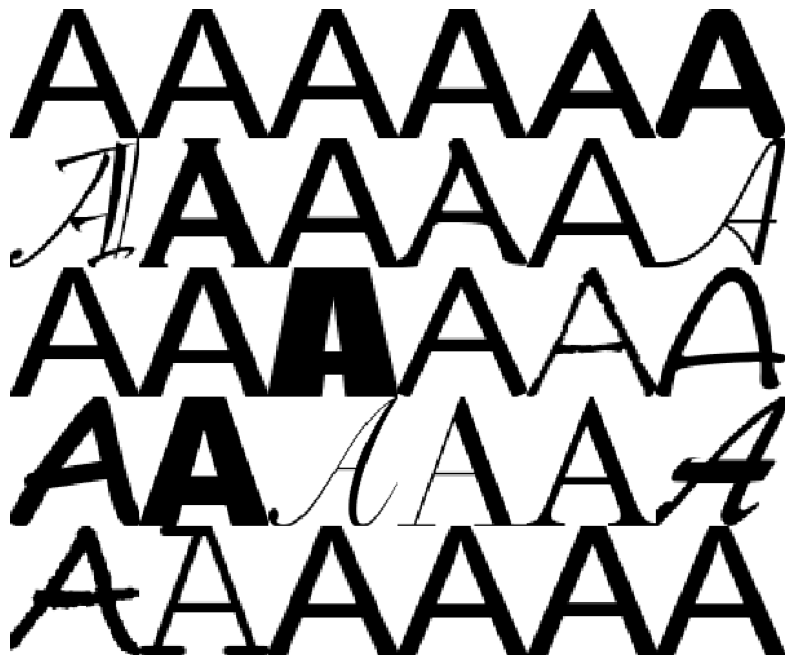

In [20]:
def show_class(character='K'):
    hstacks = []
    char_dir = os.path.join(root_folder, character)
    char_images = [resize(read(os.path.join(char_dir, x)), size=(100, 100)) for x in os.listdir(char_dir) if x.endswith('.png')]
    for i in range(5):
        imgs = char_images[i*6:(i+1)*6]
        hstacks.append(np.hstack(imgs))

    plt.figure(figsize=(10, 10))
    show(np.vstack(hstacks))

show_class('A')

#### Data

In [43]:
import glob

size_h=100
size_w=66

image_paths = sorted(glob.glob(f'{root_folder}/*/*.png'))
train_labels = np.array(list(range(26)))
classes = sorted(set([i[i.index('/')+1:i.rindex('/')] for i in image_paths]))
classes_fmap = dict(zip(classes, train_labels))
classes_imap = dict(zip(train_labels, classes))

train_images = [resize(read(x), size=(size_w, size_h))//255 for x in image_paths]
train_labels = np.stack([classes_fmap[i[i.index('/')+1:i.rindex('/')]] for i in image_paths])
train_images = np.stack(train_images)

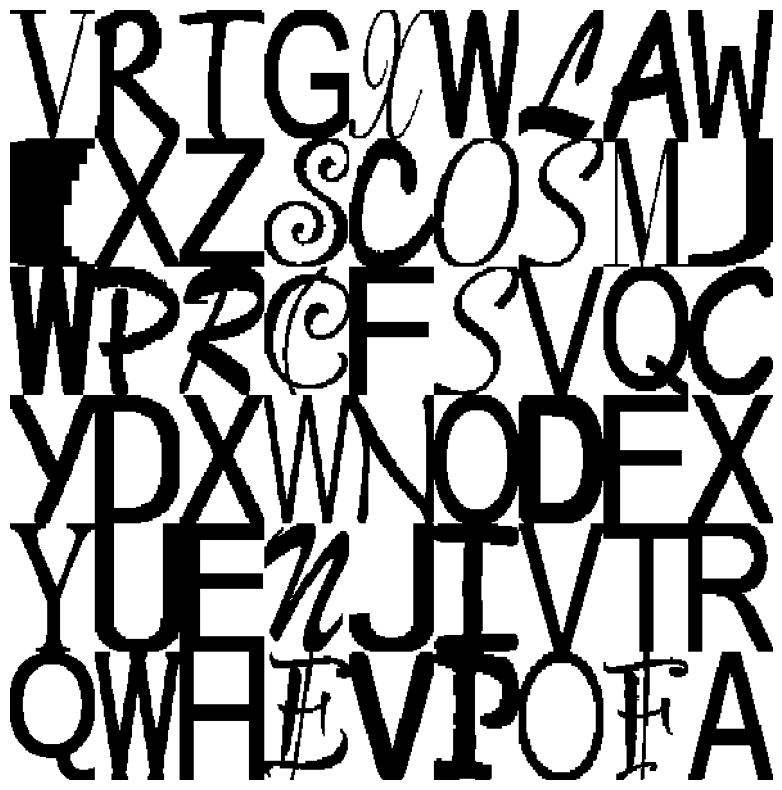

In [46]:
def random_sample(train_images):
    hstacks = []
    np.random.seed(0)
    for _ in range(6):
        idx = np.random.choice(len(train_images), 9)
        sample = train_images[idx]
        hstacks.append(np.hstack(sample))

    plt.figure(figsize=(10, 10))
    show(np.vstack(hstacks))
    
random_sample(train_images)

#### Augmentation

In [47]:
# Augmentation procedure
def augment(train_images, train_labels, 
            dilate_depth=1, 
            erode_depth=2,
            r_from=-5,
            r_to=5,
            r_step=5,
            size_h=size_h,
            size_w=size_w):
    res_images = []
    res_labels = []
    for i in range(train_images.shape[0]):
        img = train_images[i]
        l = train_labels[i]

        # rotation
        # negate for black background
        x = neg(img * 255)
        
        # First, expand the image and translate to center
        new_shape = (int(x.shape[1]*2), int(x.shape[0]*2))
        tx = (new_shape[0] - x.shape[0])/2
        ty = (new_shape[1] - x.shape[1])/2
        M = np.float32([[1,0,tx],[0,1,ty]])
        dst = cv2.warpAffine(x,M,x.shape)

        translated = cv2.warpAffine(x, M, new_shape)
        
        cx = translated.shape[0]/2
        cy = translated.shape[1]/2
        for d in range(r_from, r_to+1, r_step):
            M = cv2.getRotationMatrix2D((cx, cy),d,1) 
            rotated = cv2.warpAffine(translated, M, (int(x.shape[1]*2), int(x.shape[0]*2)))
            
            # Reverse negation
            rotated = neg(rotated)
            res_images.append(rotated)
            res_labels.append(l)
                  
            # erosion
            for it in range(1, erode_depth+1):
                rotated_and_eroded = erode(rotated, it=it)
                res_images.append(rotated_and_eroded)
                res_labels.append(l)

            # dilation
            for it in range(1, dilate_depth+1):
                rotated_and_dilated = dilate(rotated, it=it)
                res_images.append(rotated_and_dilated)
                res_labels.append(l)
        
        
    cropped_images = []
    for r in res_images:
        ys, xs = np.where(r==0)

        if len(ys) > 0 and len(xs) > 0:
            cropped = r[min(ys):max(ys)+1, min(xs):max(xs)+1]
            resized = resize(cropped, (size_w, size_h))
            if resized.shape[0] > 0:
                cropped_images.append(resized)
        
    return np.stack(cropped_images)//255,np.array(res_labels)  

Total images for training:  17472


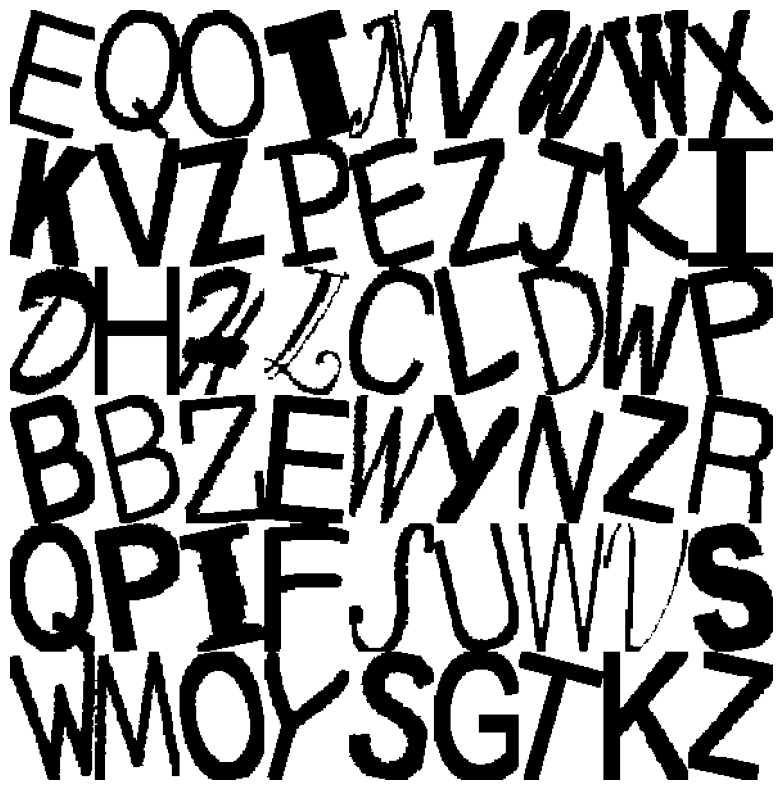

In [48]:
# Augmentation execution
erode_depth = 1
dilate_depth = 1
r_from = -15
r_to = 16
r_step = 5
train_images_augmented, train_labels_augmented = augment(train_images, train_labels, 
                                                         erode_depth=erode_depth, 
                                                         dilate_depth=dilate_depth,
                                                         r_from=r_from,
                                                         r_to=r_to,
                                                         r_step=r_step,
                                                         size_h=size_h,
                                                         size_w=size_w)
print('Total images for training: ', len(train_images_augmented))
random_sample(train_images_augmented)

In [68]:
# Test set creation
val_images = []
val_classes = []
results = {}
tests = {
    'test_set/btv.png': 'BTV',
    'test_set/multiline.png': 'FMI\nIMAGE\nPROCESSING',
    'test_set/multiline-2.png': 'TACTICAL\nDIGITAL',
    'test_set/mazalo.png': 'TOTAL SHTETA\nLESHTA BOB\nMAZZALLO',
    'test_set/team.png': 'TEAM',
    'test_set/fmi.png': 'FMI',
    'test_set/digital.png': 'DIGITAL',
    'test_set/tactical.png': 'TACTICAL',
    'test_set/ocr.png': 'OCR',
    'test_set/test.png': 'TEST',
    'test_set/nova.png': 'NOVA',
    'test_set/image.png': 'IMAGE',
    'test_set/processing.png': 'PROCESSING',
    'test_set/trt1.png': 'TEXT\nRECOGNITION\nPROGRAM\nTEXT',
    'test_set/vasko.png': 'VASKO THE\nFROG'
}

for t, label in tests.items():
    char_count = 0
    for line in pipeline_2(t):
        for word in line:
            for c in word:
                cropped_char = c[0]
 
                letter_img_res = bin_simple(resize(cropped_char, (size_w, size_h)))//255
                val_images.append(letter_img_res)

                l = label[char_count].upper()
                clazz = classes_fmap[l]
                val_classes.append(clazz)
                char_count+=1
            char_count+=1 # space should be counted as character

val_images = np.stack(val_images)
val_classes = np.array(val_classes)
len(val_images), len(val_classes)

(150, 150)

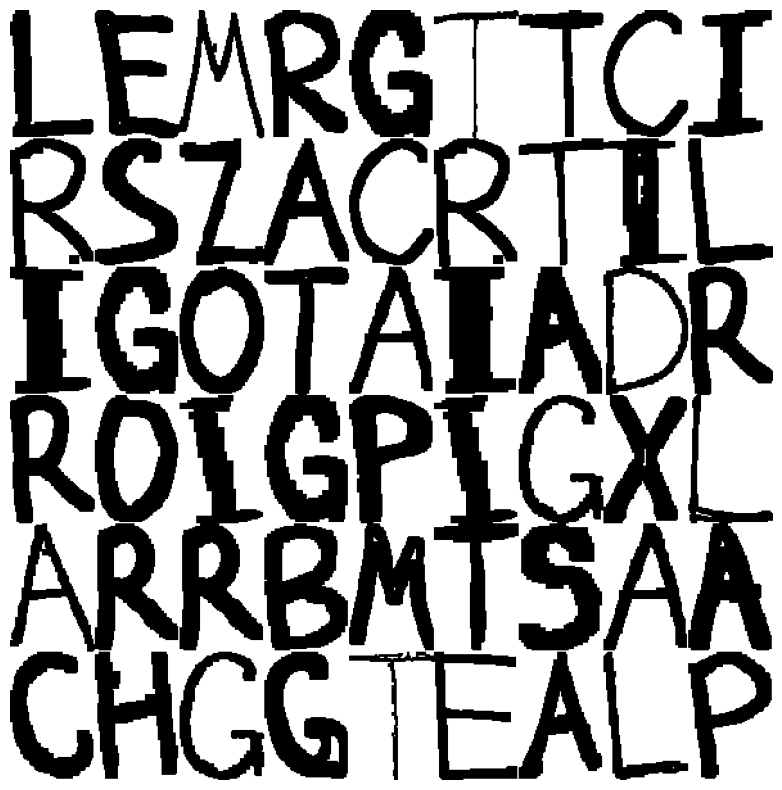

In [69]:
random_sample(val_images)

#### Model

In [21]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

tf.keras.utils.set_random_seed(0)
np.random.seed(0)

epochs = 15

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size_h, size_w, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(language), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 30, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 13, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 17472)             0

In [42]:
# Shuffle - model should not observe "sequential" classes - 33 "A", 33 "B", etc.
idx = np.random.permutation(len(train_images_augmented))
train_images_augmented, train_labels_augmented = train_images_augmented[idx], train_labels_augmented[idx]
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

mcp_save = tf.keras.callbacks.ModelCheckpoint('model_best_100_60_x.h5', save_best_only=True, monitor='val_accuracy', mode='max')
history = model.fit(train_images_augmented, train_labels_augmented, 
                    epochs=epochs, validation_data=(val_images, val_classes), callbacks=[mcp_save])


Epoch 1/15
546/546 [==============================] - 23s 42ms/step - loss: 0.4796 - accuracy: 0.8679 - val_loss: 0.7882 - val_accuracy: 0.8667
Epoch 2/15
546/546 [==============================] - 22s 41ms/step - loss: 0.0633 - accuracy: 0.9813 - val_loss: 1.0969 - val_accuracy: 0.8733
Epoch 3/15
546/546 [==============================] - 22s 40ms/step - loss: 0.0358 - accuracy: 0.9899 - val_loss: 0.7566 - val_accuracy: 0.9067
Epoch 4/15
546/546 [==============================] - 22s 41ms/step - loss: 0.0245 - accuracy: 0.9923 - val_loss: 0.9305 - val_accuracy: 0.9133
Epoch 5/15
546/546 [==============================] - 22s 41ms/step - loss: 0.0154 - accuracy: 0.9960 - val_loss: 0.9320 - val_accuracy: 0.8933
Epoch 6/15
546/546 [==============================] - 23s 42ms/step - loss: 0.0188 - accuracy: 0.9942 - val_loss: 0.8006 - val_accuracy: 0.9200
Epoch 7/15
546/546 [==============================] - 23s 43ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.8625 - val_accuracy:

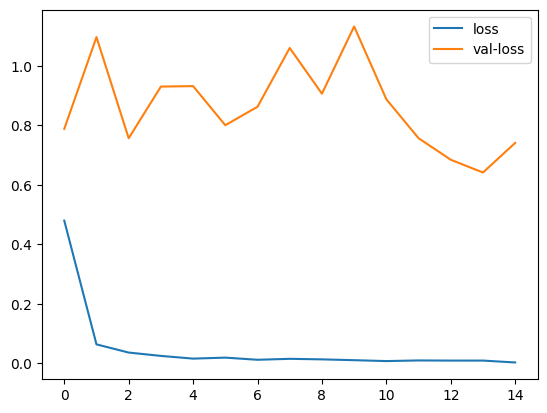

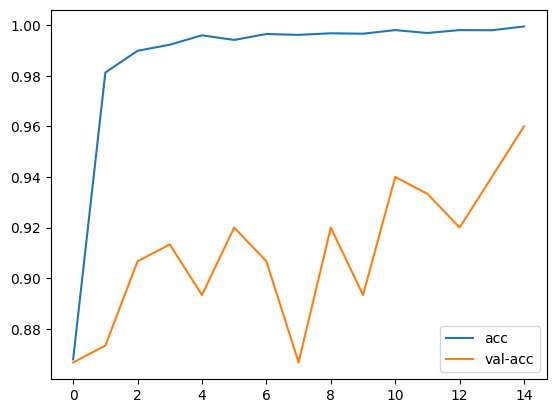

In [43]:
pd.Series(history.history['loss']).plot()
pd.Series(history.history['val_loss']).plot()
plt.legend(['loss', 'val-loss'])
plt.show()
pd.Series(history.history['accuracy']).plot()
pd.Series(history.history['val_accuracy']).plot()
plt.legend(['acc', 'val-acc'])


In [53]:
model = tf.keras.models.load_model('model_best_100_60.h5')

In [54]:
def classify_nn(letter_img, inference_size=(size_w, size_h), _filter='.png'):
    letter_img_res = bin_simple(resize(letter_img, inference_size))//255
    letter_img_tensor = np.stack([letter_img_res])
        
    results = model.predict(letter_img_tensor, verbose=False)
    char_idx = np.argmax(results)
    character = classes_imap[char_idx][0]
    return character, results

def ocr(path, show_steps, class_fn):
    lines = pipeline_2(path, show_steps=show_steps)
    text = ''
    for il, line in enumerate(lines):
        for iw, word in enumerate(line):
            for c, *_ in word:
                char = class_fn(c)[0]
                text += char
            if iw != len(line) - 1:
                text += ' '
        if il != len(lines) - 1:
            text += '\n'
    return text

def ocr_nn(path, show_steps=False):
    return ocr(path, show_steps, classify_nn)

#### Tests NN

In [56]:
ocr_nn('test_set/nova.png', show_steps=False)

2023-01-10 23:31:06.341644: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


'NOVA'

In [57]:
ocr_nn('test_set/btv.png', show_steps=False)

'BTV'

In [58]:
len(tests)

15

In [59]:
sum([len(x) for x in list(tests.values())])

162

In [70]:
# Model check 
results = {}
fns = [ocr_nn]
tests = {
    'test_set/btv.png': 'BTV',
    'test_set/multiline.png': 'FMI\nIMAGE\nPROCESSING',
    'test_set/multiline-2.png': 'TACTICAL\nDIGITAL',
    'test_set/mazalo.png': 'TOTAL SHTETA\nLESHTA BOB\nMAZZALLO',
    'test_set/team.png': 'TEAM',
    'test_set/fmi.png': 'FMI',
    'test_set/digital.png': 'DIGITAL',
    'test_set/tactical.png': 'TACTICAL',
    'test_set/ocr.png': 'OCR',
    'test_set/test.png': 'TEST',
    'test_set/nova.png': 'NOVA',
    'test_set/image.png': 'IMAGE',
    'test_set/processing.png': 'PROCESSING',
    'test_set/trt1.png': 'TEXT\nRECOGNITION\nPROGRAM\nTEXT',
    'test_set/vasko.png': 'VASKO THE\nFROG',
         
    # Add a screenshot
    'test_set/shot.png': 'OCR\nGEORGI PACHOV\nIMAGE PROCESSING\nCOURSE'
}

# Check metrics and print letter confusions
errors = []
for fn in fns:
    num_correct = 0
    num_total = 0
    
    for t, label in tests.items():
        num_total += len(label)

        result = ''.join(fn(t))
        
        letter_map = {}
        char_count = 0
        for line in pipeline_2(t):
            for word in line:
                for c in word:
                    cropped_char = c[0]

                    letter_img_res = bin_simple(resize(cropped_char, (size_w, size_h)))//255
                    letter_map[char_count] = letter_img_res
                    char_count+=1
                char_count+=1 # space should be counted as character
                
        for i in range(min(len(label), len(result))):
            if label[i] == result[i]:
                num_correct+=1
            else:
                errors.append((i, label[i], result[i], t, letter_map[i]))
        print(t, result)
        
    results[fn] = num_correct/num_total
print('Accuracy:', results)

print('Errors')
for p in errors:
    print(f'Letter with index {p[0]} -> {p[1]} was confused with {p[2]} in {p[3]}')

test_set/btv.png BTV
test_set/multiline.png FMI
IMAGE
PROCESSLNG
test_set/multiline-2.png TACTICAL
DIGITAL
test_set/mazalo.png TOTAL SHTETA
LESHTA BOB
MAZZRLLO
test_set/team.png TEAM
test_set/fmi.png FMI
test_set/digital.png DIGITAL
test_set/tactical.png TACTICAL
test_set/ocr.png OCR
test_set/test.png TEST
test_set/nova.png NOVA
test_set/image.png IMAGE
test_set/processing.png PROCESSLNG
test_set/trt1.png TEXT
RECOGNXTIQN
PROGRAM
TEST
test_set/vasko.png VASKO THE
FROG
test_set/shot.png OCR
GEORGI PACHOV
IMAGE PROCESSING
COURSE
Accuracy: {<function ocr_nn at 0x28404bd90>: 0.9704433497536946}
Errors
Letter with index 17 -> I was confused with L in test_set/multiline.png
Letter with index 28 -> A was confused with R in test_set/mazalo.png
Letter with index 7 -> I was confused with L in test_set/processing.png
Letter with index 11 -> I was confused with X in test_set/trt1.png
Letter with index 14 -> O was confused with Q in test_set/trt1.png
Letter with index 27 -> X was confused with S in

## Demonstration

#### Multiline

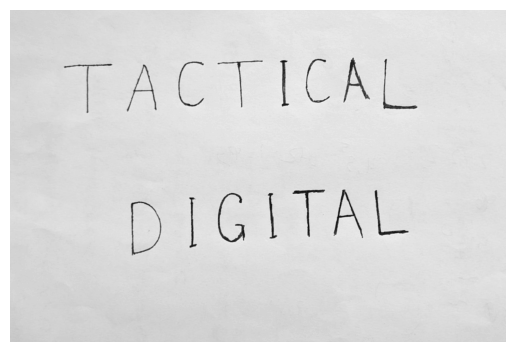

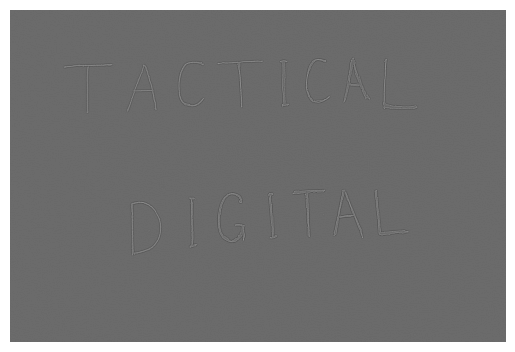

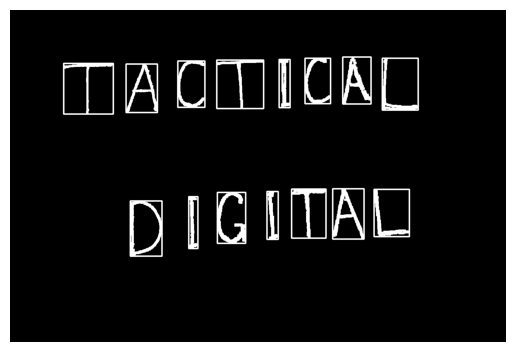

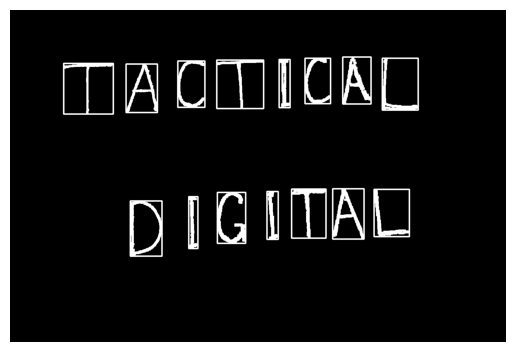

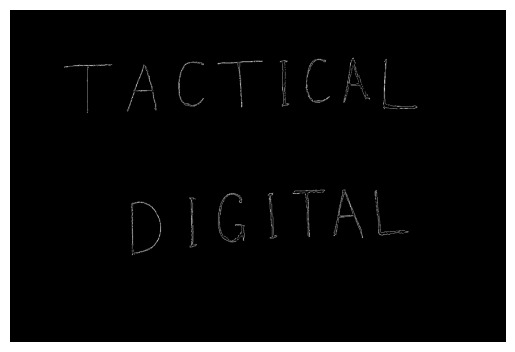

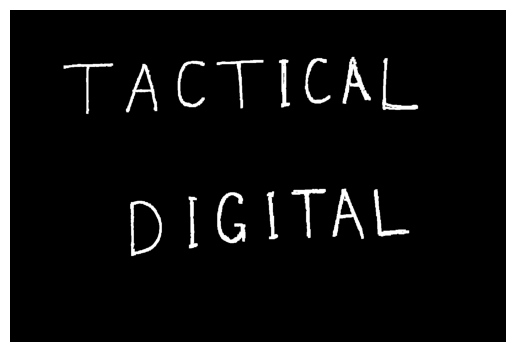

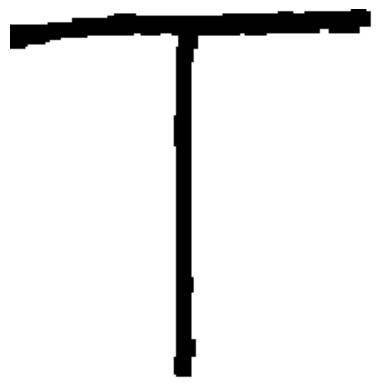

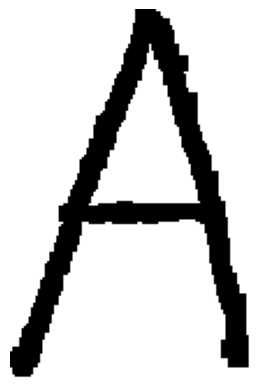

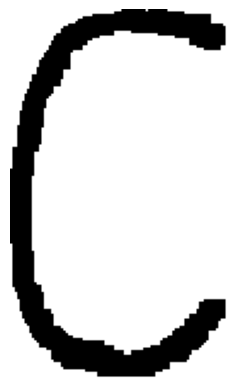

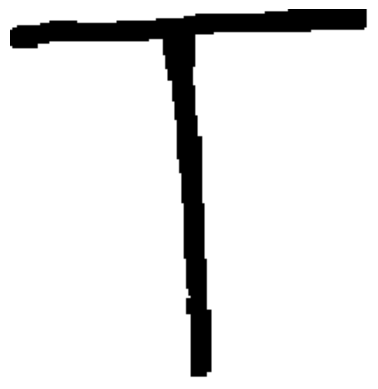

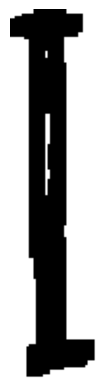

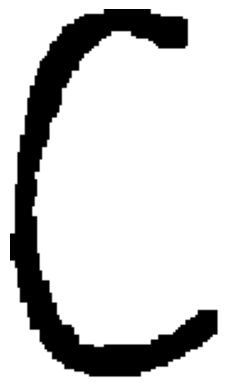

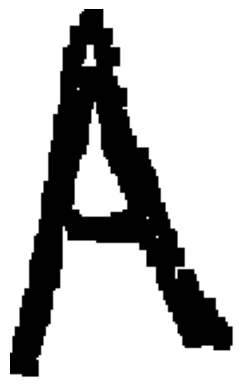

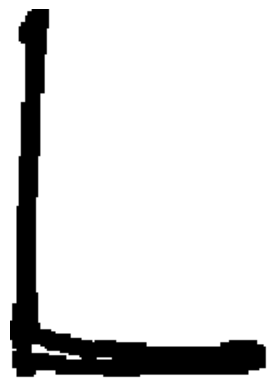

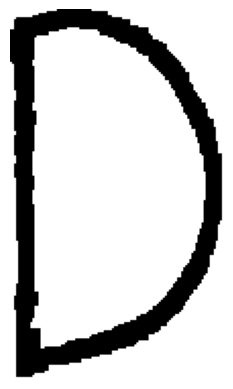

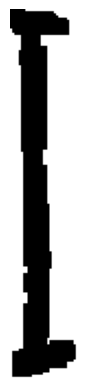

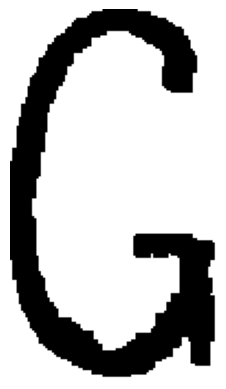

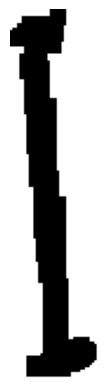

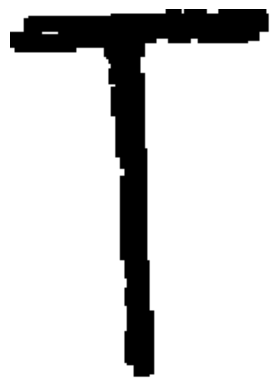

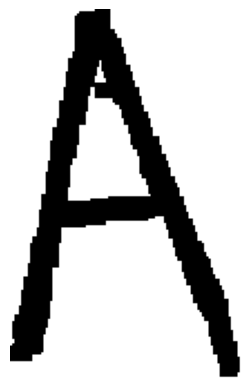

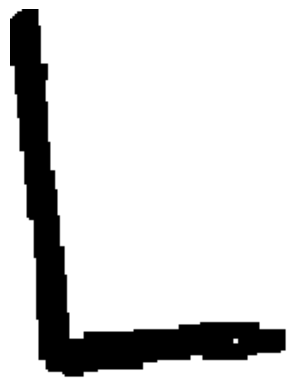

TACTICAL
DIGITAL


In [71]:
r = ocr_nn('test_set/multiline-2.png', show_steps=True)
print(r)

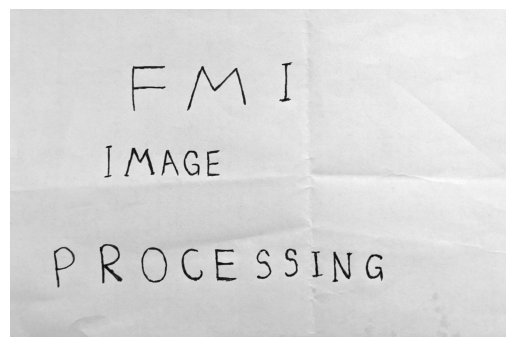

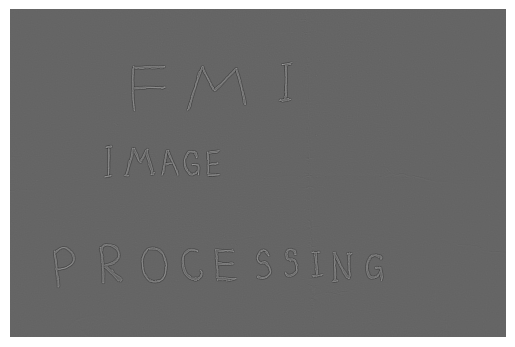

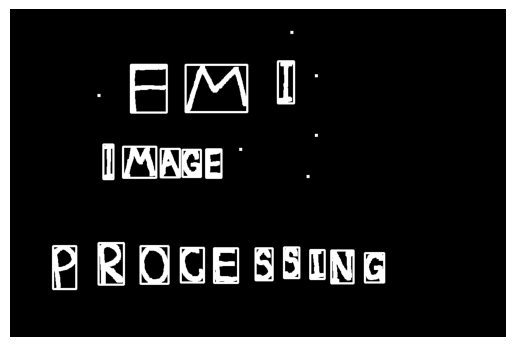

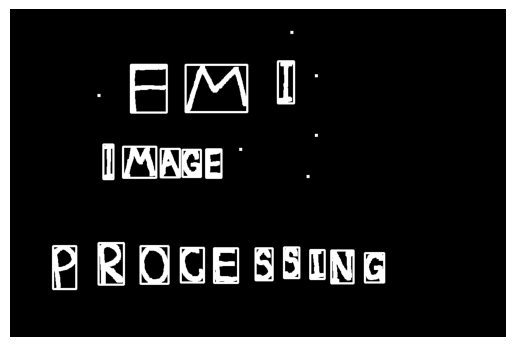

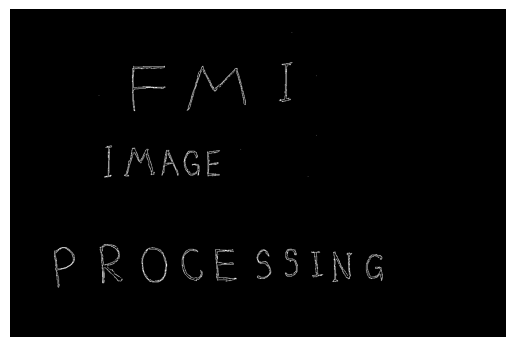

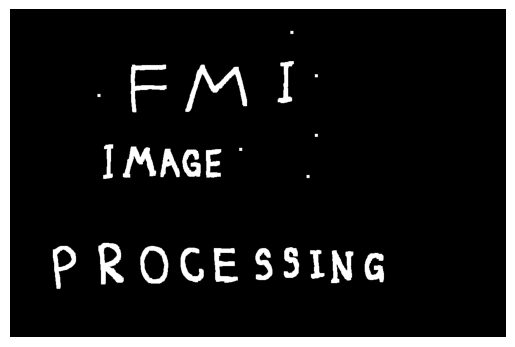

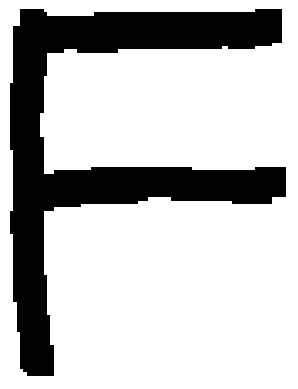

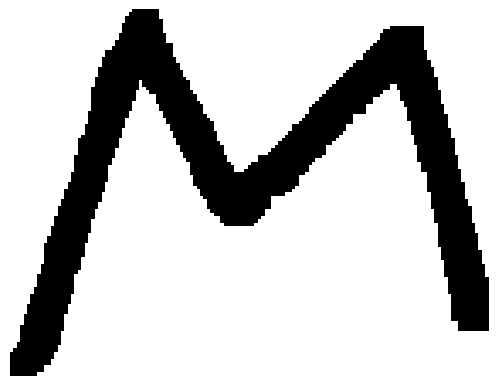

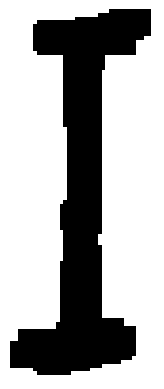

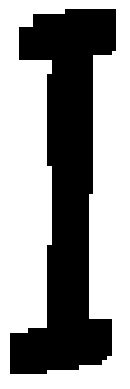

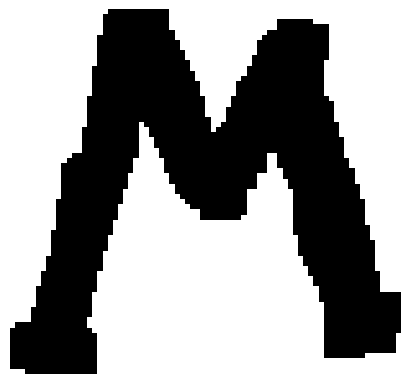

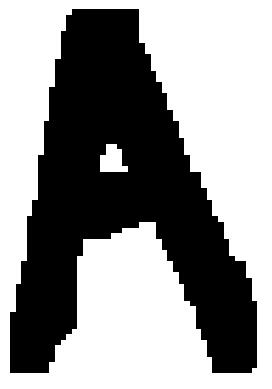

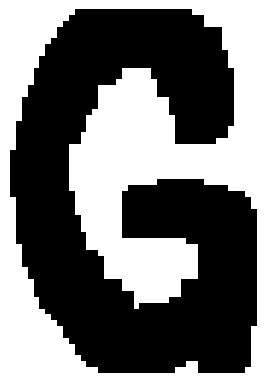

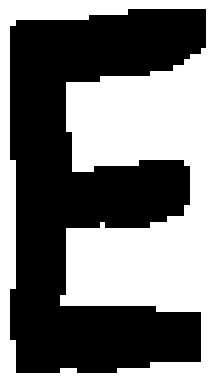

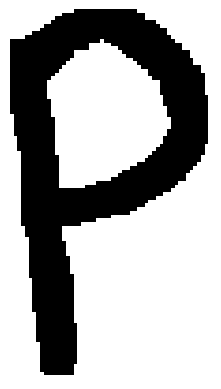

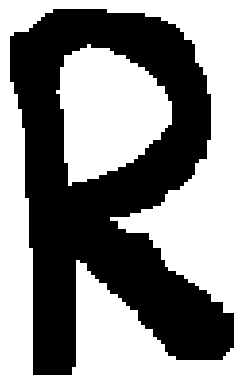

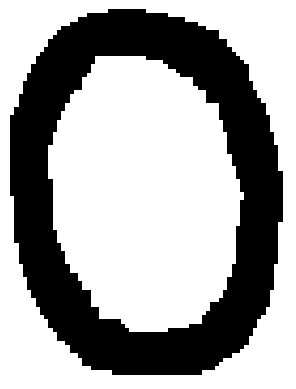

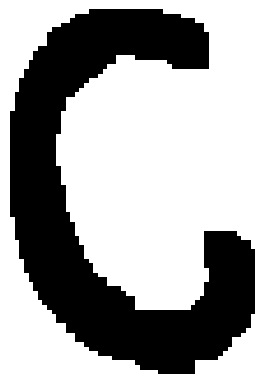

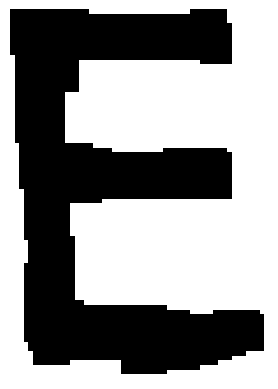

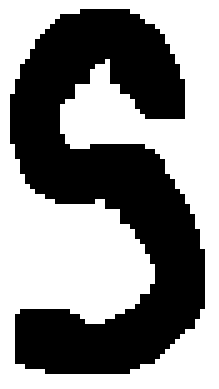

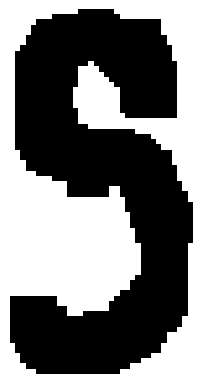

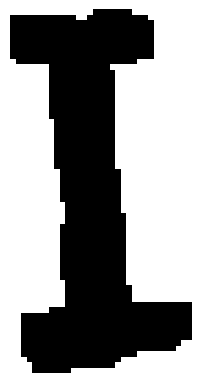

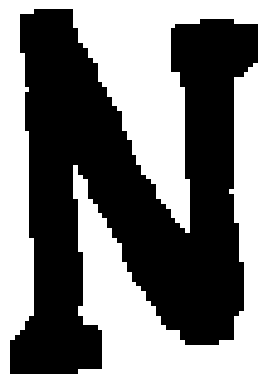

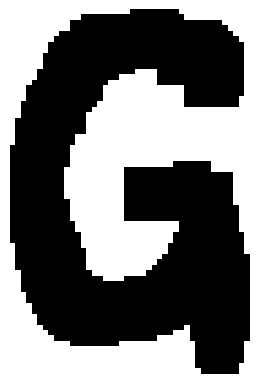

FMI
IMAGE
PROCESSLNG


In [66]:
r = ocr_nn('test_set/multiline.png', show_steps=True)
print(r)

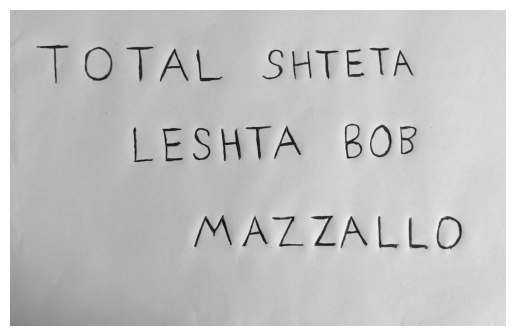

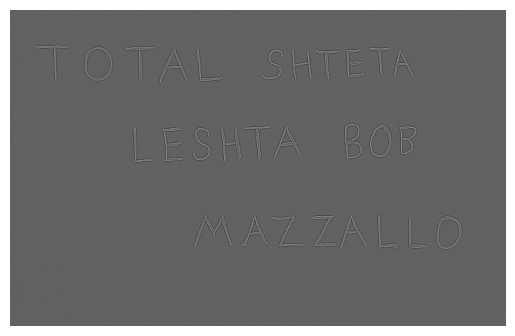

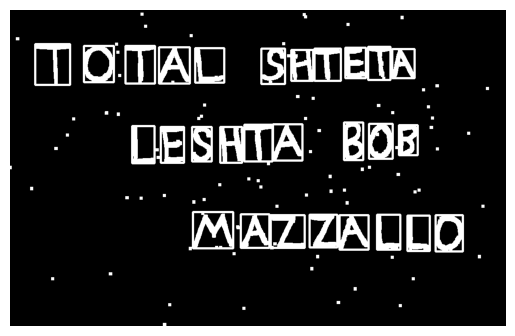

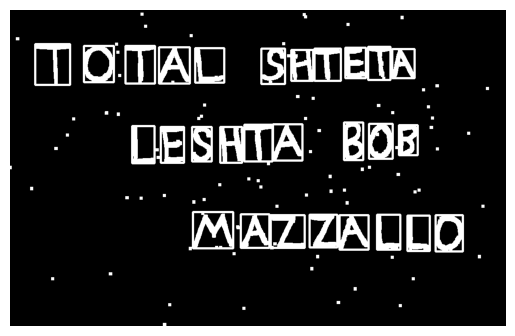

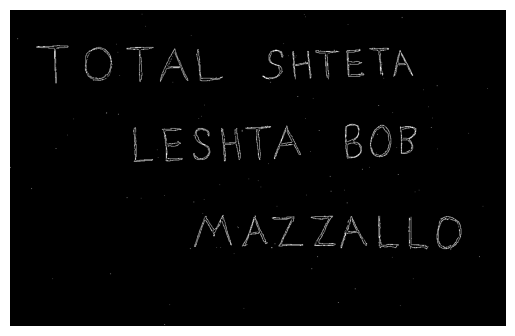

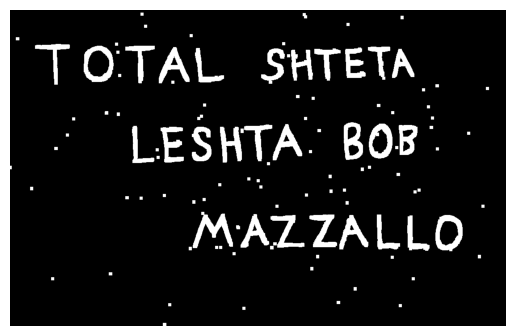

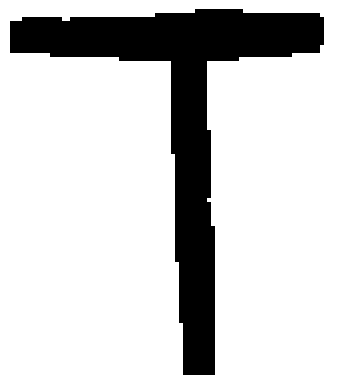

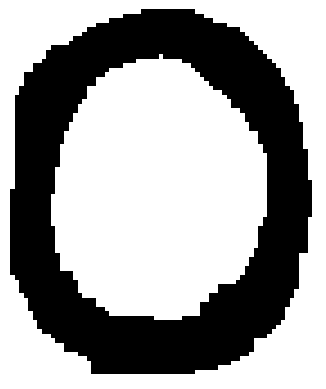

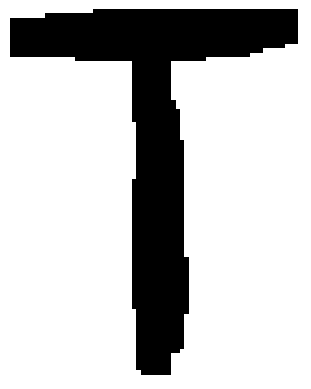

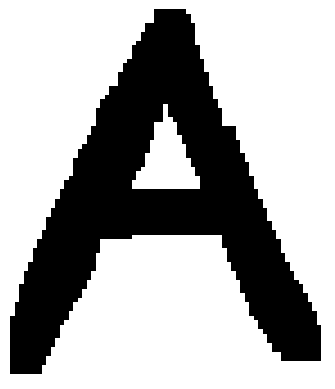

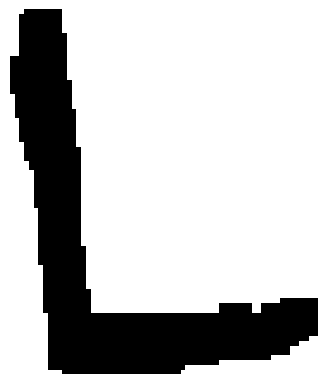

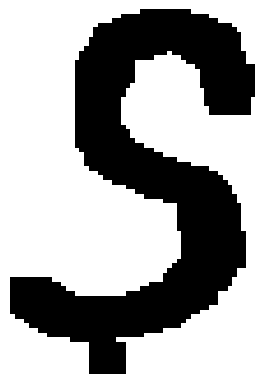

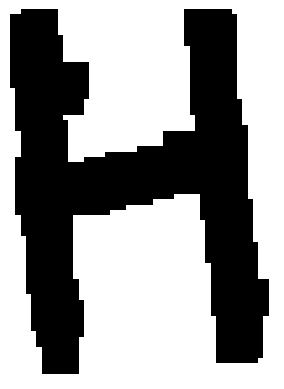

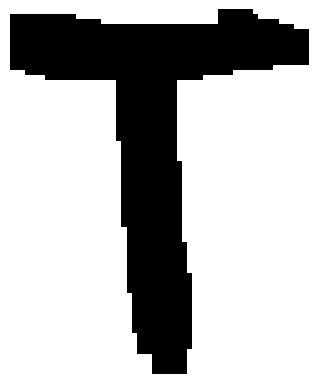

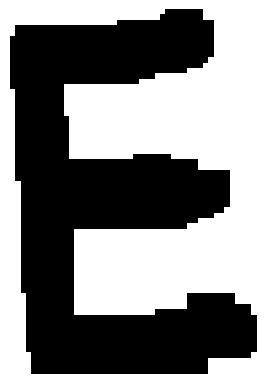

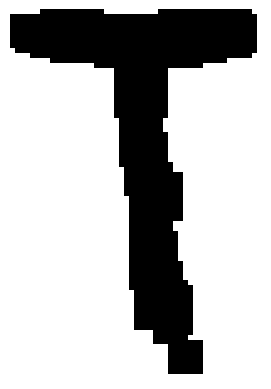

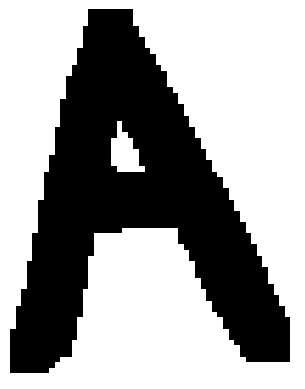

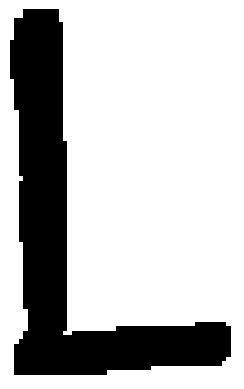

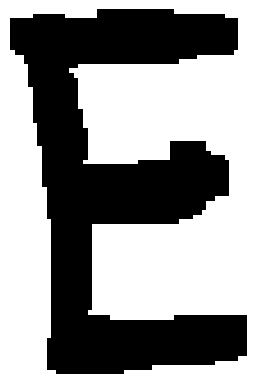

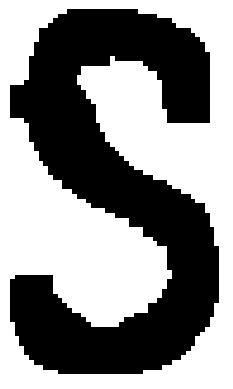

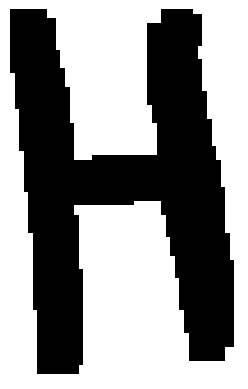

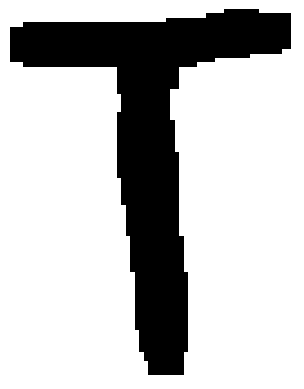

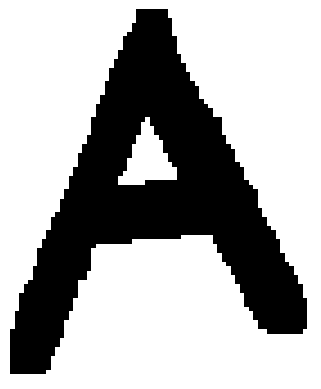

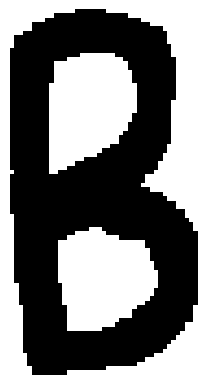

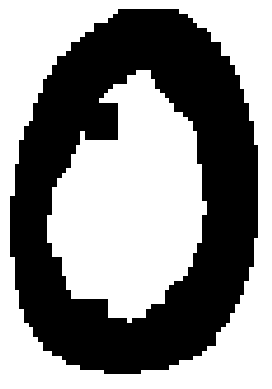

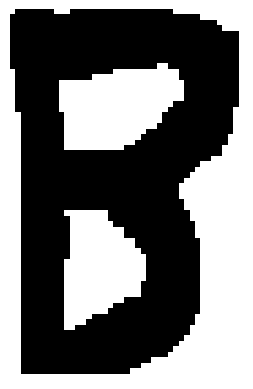

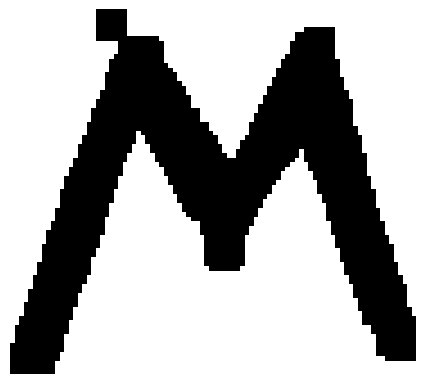

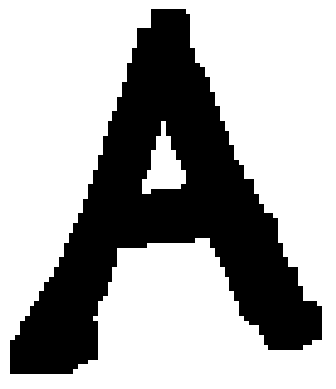

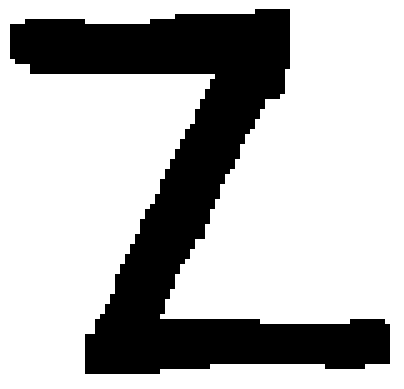

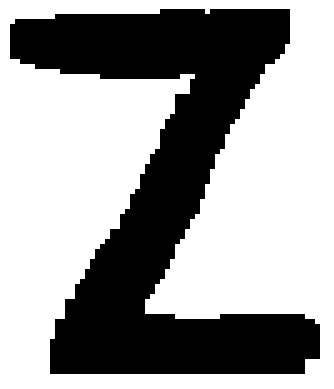

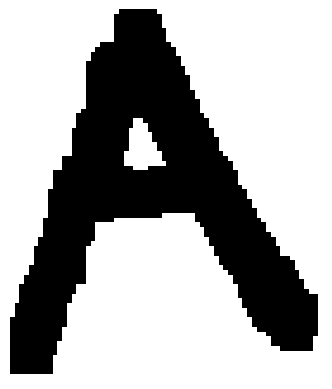

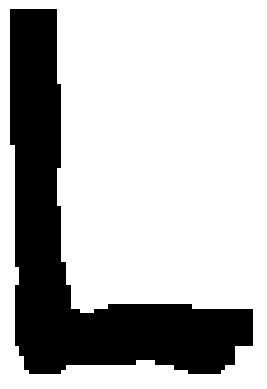

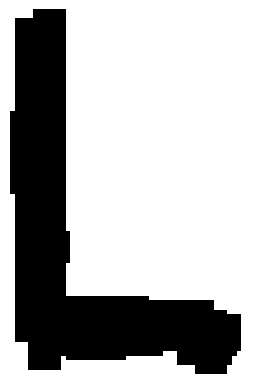

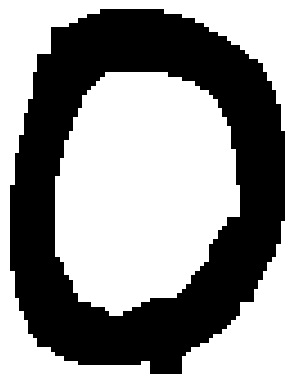

'TOTAL SHTETA\nLESHTA BOB\nMAZZRLLO'

In [67]:
ocr_nn('test_set/mazalo.png', show_steps=True)

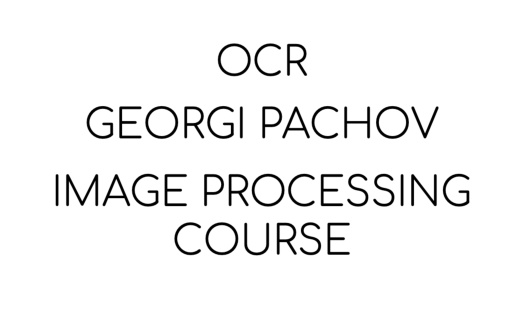

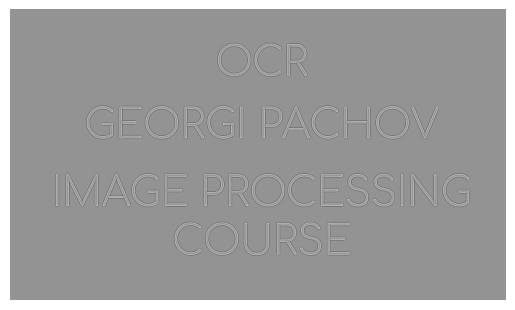

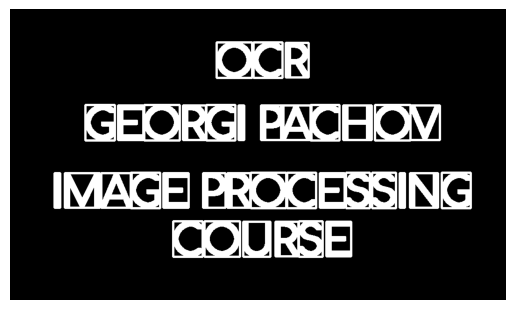

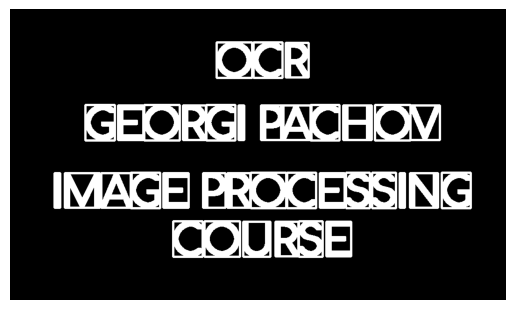

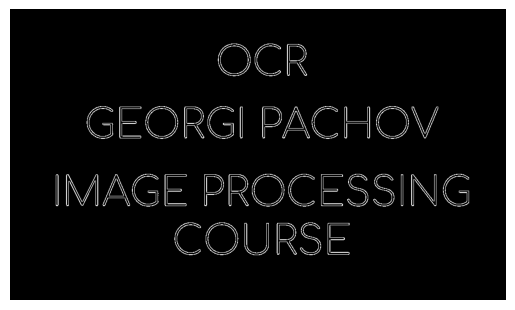

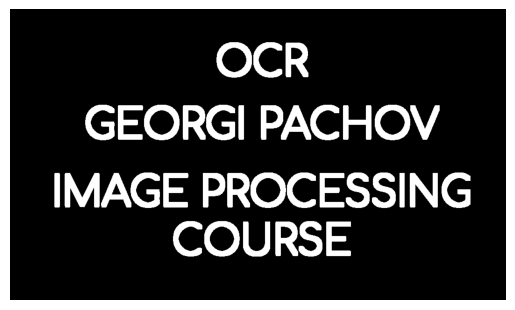

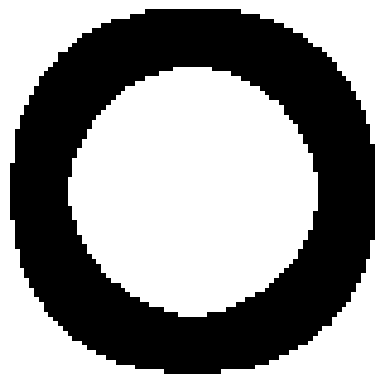

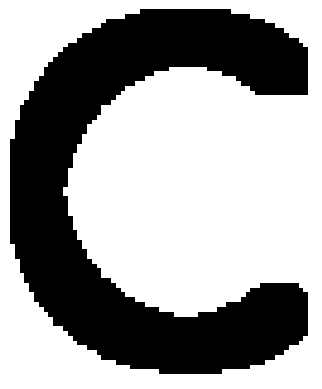

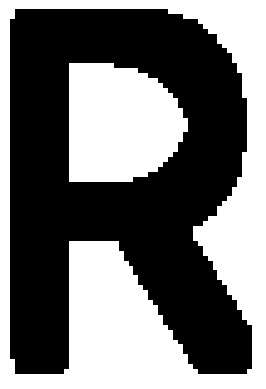

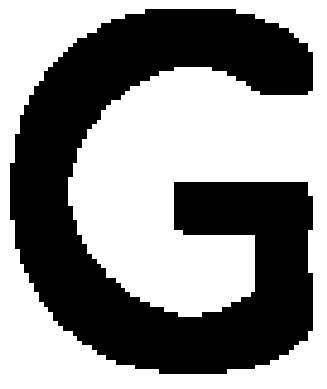

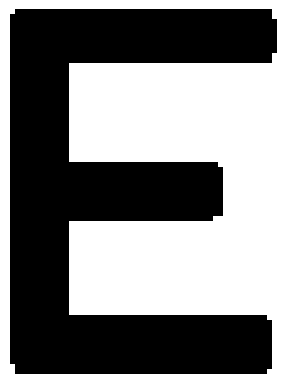

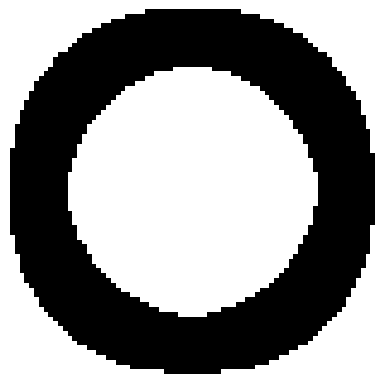

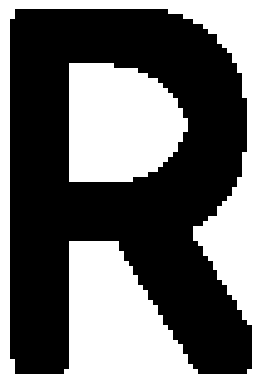

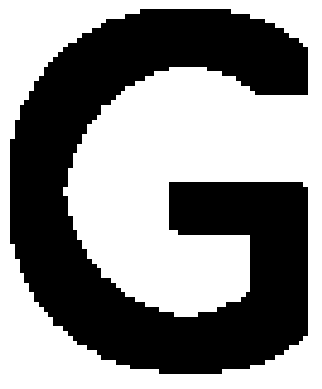

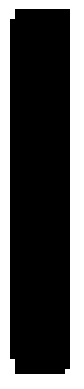

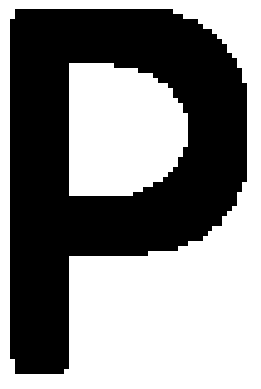

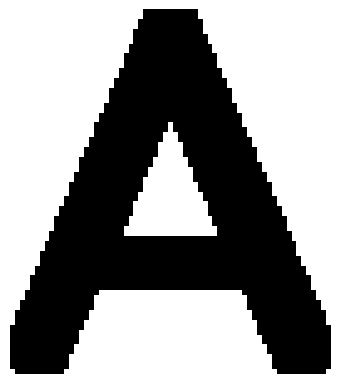

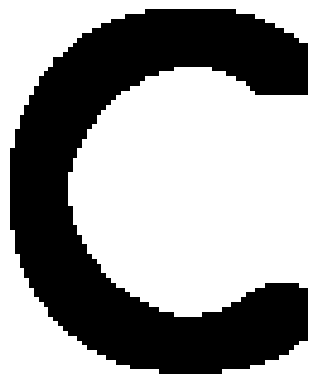

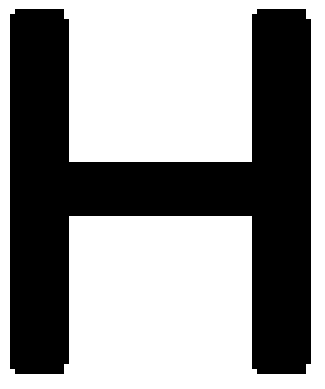

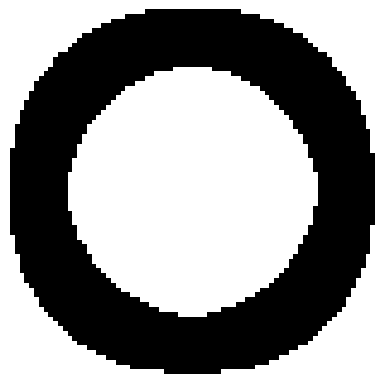

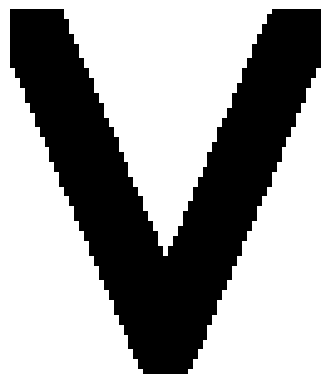

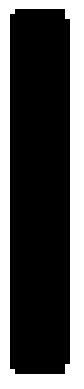

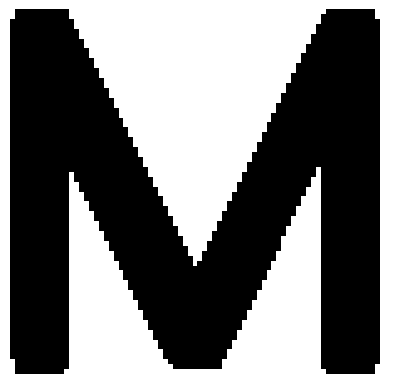

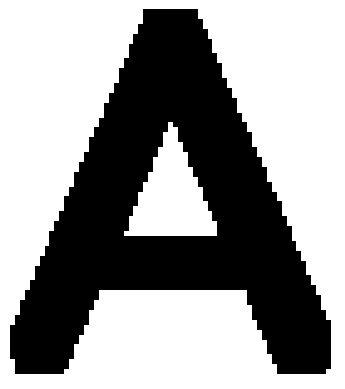

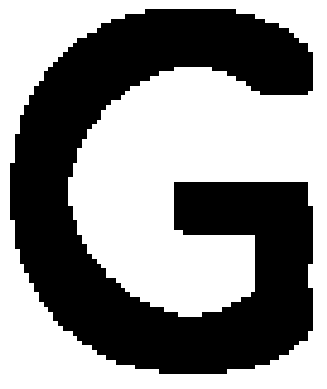

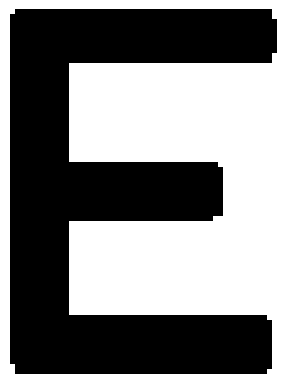

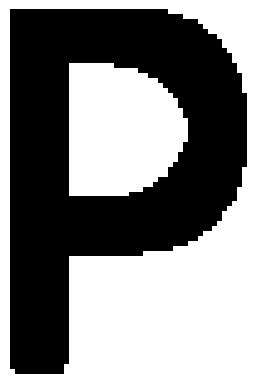

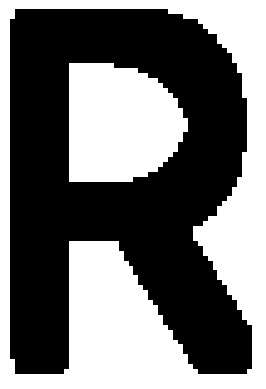

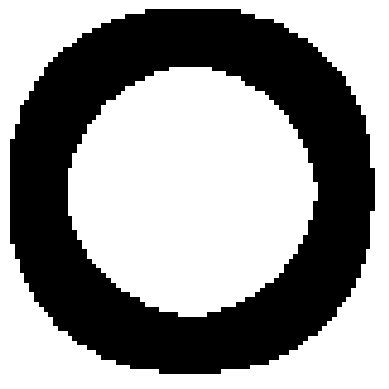

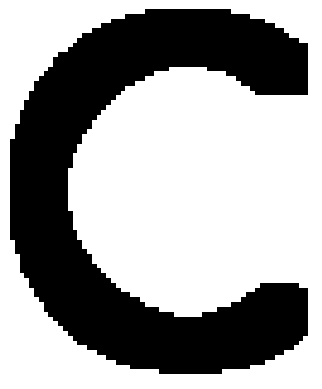

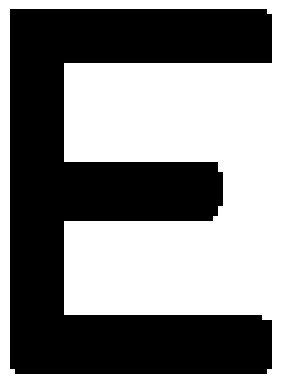

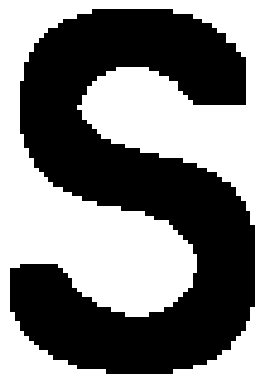

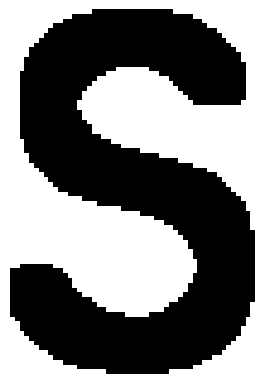

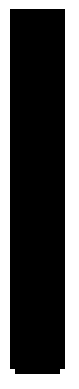

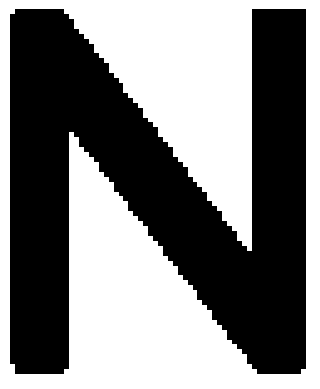

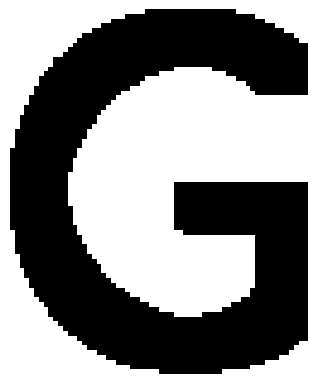

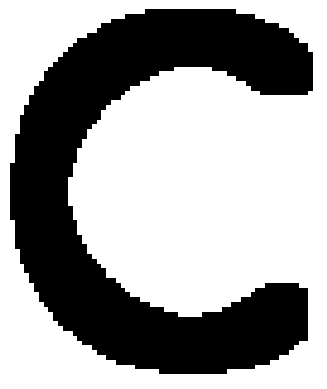

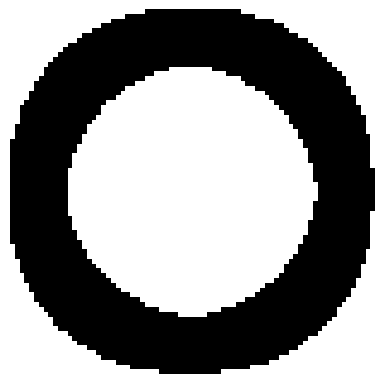

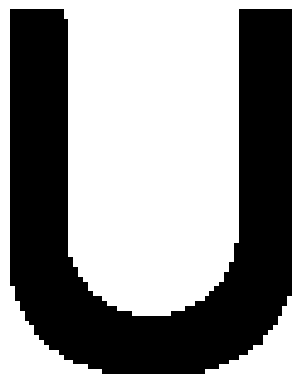

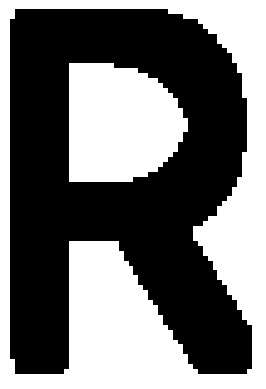

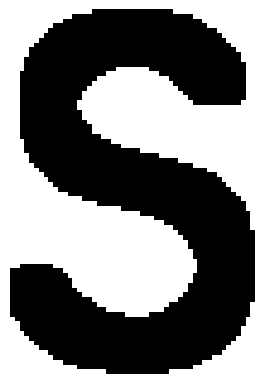

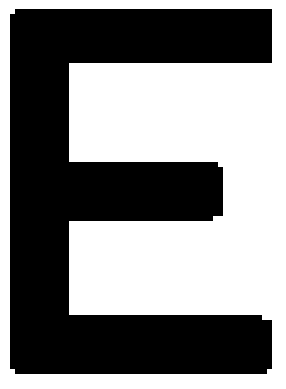

'OCR\nGEORGI PACHOV\nIMAGE PROCESSING\nCOURSE'

In [101]:
# Screenshot
ocr_nn('shot.png', show_steps=True)